In [63]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import roc_auc_score, r2_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
from sklearn import linear_model, discriminant_analysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


import warnings
warnings.filterwarnings("ignore")

In [64]:
df = pd.read_csv('Data/diabetes.csv')

In [65]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,diabetes
0,Female,80.0,0,1,never,25.19,0
1,Female,54.0,0,0,No Info,27.32,0
2,Male,28.0,0,0,never,27.32,0
3,Female,36.0,0,0,current,23.45,0
4,Male,76.0,1,1,current,20.14,0


In [66]:
df = pd.get_dummies(df, drop_first=True)
df

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,0,True,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,80.0,0,0,27.32,0,False,False,False,False,False,False,False
99996,2.0,0,0,17.37,0,False,False,False,False,False,False,False
99997,66.0,0,0,27.83,0,True,False,False,False,True,False,False
99998,24.0,0,0,35.42,0,False,False,False,False,False,True,False


In [67]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop')+1
    grouped = df_calibracion.groupby('bins').mean()

    plt.plot(grouped.predicciones, grouped.y, label="Modelo", marker="o")
    plt.plot(grouped.predicciones, grouped.predicciones, label="Real", marker="o")
    plt.grid()
    plt.legend()
    plt.xlabel("Prediccion")
    plt.ylabel("Real")

In [68]:
target= 'diabetes'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# KNN

In [69]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalización de datos
    ('knn', KNeighborsClassifier())  
])

params_grid = {
    'knn__n_neighbors': range(1, 50), 
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan'] 
}

random_seach = RandomizedSearchCV(estimator=pipeline, 
                                  param_distributions=params_grid, n_iter=15, cv=5, n_jobs=-1, scoring='roc_auc')

random_seach.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('knn', KNeighborsClassifier())]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'knn__metric': ['euclidean',
                                                        'manhattan'],
                                        'knn__n_neighbors': range(1, 50),
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   scoring='roc_auc')

In [70]:
random_seach.best_params_

{'knn__weights': 'uniform', 'knn__n_neighbors': 43, 'knn__metric': 'manhattan'}

In [71]:
random_knn = random_seach.best_estimator_.predict_proba(X_test)[:,1]
print("AUC", roc_auc_score(y_score=random_knn, y_true=y_test))

AUC 0.8177404050144648


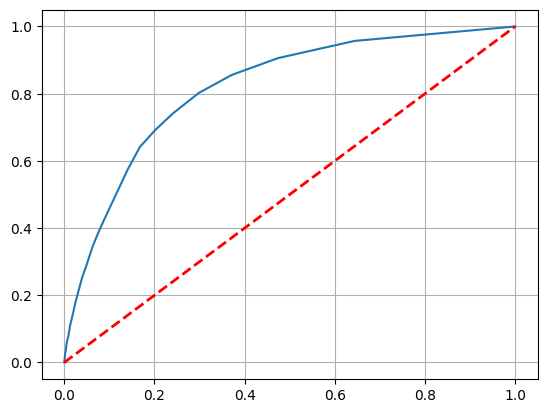

In [72]:
fpr, fnp, scores = roc_curve(y_score=random_knn, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

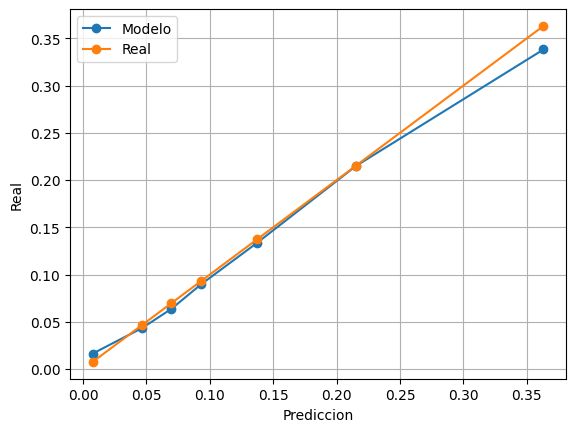

In [73]:
calibracion(random_knn, y_test, 10)

# Regresion Logistica

In [74]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),  # grado se definirá en grid search
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=10000, random_state=42))
])

params_grid = {
    'poly__degree':[1,2,3],
    'logreg__penalty':['l2', None],
    'logreg__C':[0.01, 0.1, 1]
}

In [75]:
log_reg_random = RandomizedSearchCV(estimator=pipeline, cv=5, n_jobs=-1,
                                    scoring='roc_auc',
                                    param_distributions=params_grid,
                                    n_iter=5)

log_reg_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('poly',
                                              PolynomialFeatures(include_bias=False)),
                                             ('scaler', StandardScaler()),
                                             ('logreg',
                                              LogisticRegression(max_iter=10000,
                                                                 random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'logreg__C': [0.01, 0.1, 1],
                                        'logreg__penalty': ['l2', None],
                                        'poly__degree': [1, 2, 3]},
                   scoring='roc_auc')

In [76]:
log_reg_random.best_params_

{'poly__degree': 2, 'logreg__penalty': None, 'logreg__C': 1}

In [77]:
probabilites_log_reg_random = log_reg_random.best_estimator_.predict_proba(X_test)[:,1]

print("AUC",roc_auc_score(y_score=probabilites_log_reg_random, y_true=y_test))

AUC 0.8401692381870781


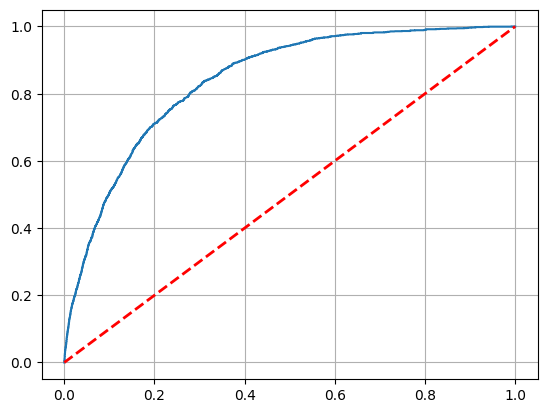

In [78]:
fpr, fnp, scores = roc_curve(y_score=probabilites_log_reg_random, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

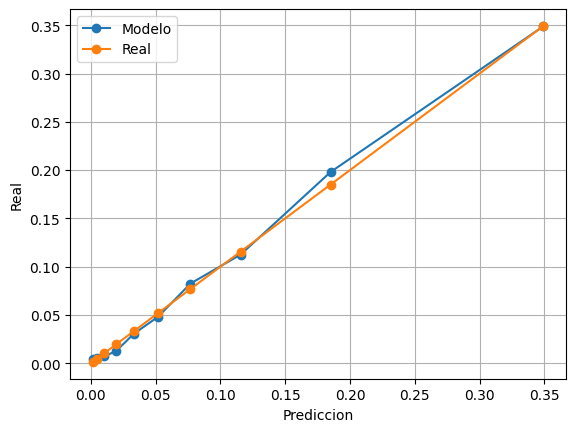

In [79]:
calibracion(probabilites_log_reg_random, y_test, 10)

# Variables regresión logistica

In [80]:
variables = log_reg_random.best_estimator_.named_steps['poly'].get_feature_names_out(X_train.columns)
coeficientes = log_reg_random.best_estimator_.named_steps['logreg'].coef_[0]

model_coeficientes = pd.DataFrame({
          'Variable': variables,
          'Coeficiente': coeficientes
})
model_coeficientes = model_coeficientes.sort_values(by='Coeficiente', ascending=False).head()
model_coeficientes

,Variable,Coeficiente
0,age,1.431209
3,bmi,0.718044
14,age bmi,0.635118
22,hypertension^2,0.384531
1,hypertension,0.384531


Analizando las variables nos damos que las variables con un mayor coeficiente son age, bmi, age bmi, hypertension^2 e hypertension, lo que nos dice que con el crecimientos de estas variables su log loss aumenta, estas variables son las más importantes al momento de predecir si una persona tiene diabetes o no, podemos ver que age y bmi son variables bastante importantes para esta predicción junto a hypertension.

# Analisis del discriminante lineal

In [81]:
pipeline = Pipeline([
    ("scaler",  StandardScaler()),
    ("model", discriminant_analysis.LinearDiscriminantAnalysis())
])

pipeline.fit(X_train, y_train)

probabilidades_modelo_disc = pipeline.predict_proba(X_test)[:, 1]
print("AUC", roc_auc_score(y_score=probabilidades_modelo_disc, y_true=y_test))

AUC 0.8307843137254902


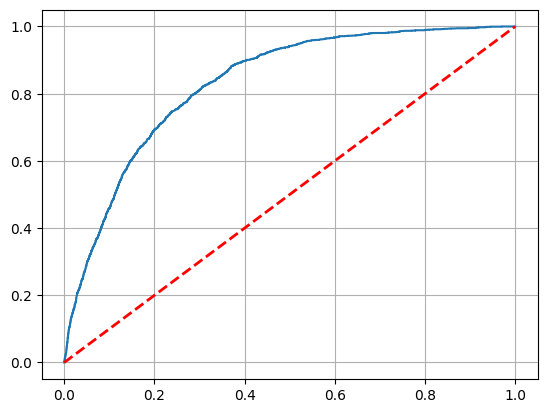

In [82]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_modelo_disc, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

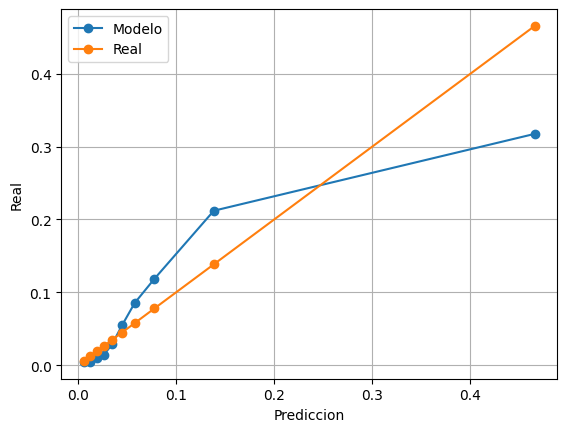

In [83]:
calibracion(probabilidades_modelo_disc, y_test, 10)

# Red Neuronal

In [84]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier(max_iter=1000, random_state=42))
])

# Params grid
params_grid = {
     'nn__hidden_layer_sizes': [(50,50,50), (10,), (100,), (10,10)],
     'nn__activation': ['tanh', 'relu', 'logistic'],
     'nn__alpha': [0.1, 0.01]
}

# Fit 
grid_nn = RandomizedSearchCV(estimator=pipeline, n_jobs=-1, cv=5, scoring='roc_auc', param_distributions=params_grid)

grid_nn.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('nn',
                                              MLPClassifier(max_iter=1000,
                                                            random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'nn__activation': ['tanh', 'relu',
                                                           'logistic'],
                                        'nn__alpha': [0.1, 0.01],
                                        'nn__hidden_layer_sizes': [(50, 50, 50),
                                                                   (10,),
                                                                   (100,),
                                                                   (10, 10)]},
                   scoring='roc_auc')

In [85]:
grid_nn.best_params_

{'nn__hidden_layer_sizes': (10, 10),
 'nn__alpha': 0.1,
 'nn__activation': 'tanh'}

In [86]:
nn_predictions = grid_nn.best_estimator_.predict_proba(X_test)[:,1]
print("AUC", roc_auc_score(y_score=nn_predictions, y_true=y_test))

AUC 0.8394162005785921


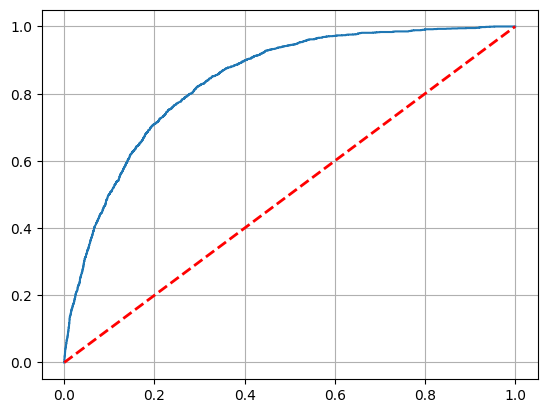

In [87]:
fpr, fnp, scores = roc_curve(y_score=nn_predictions, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

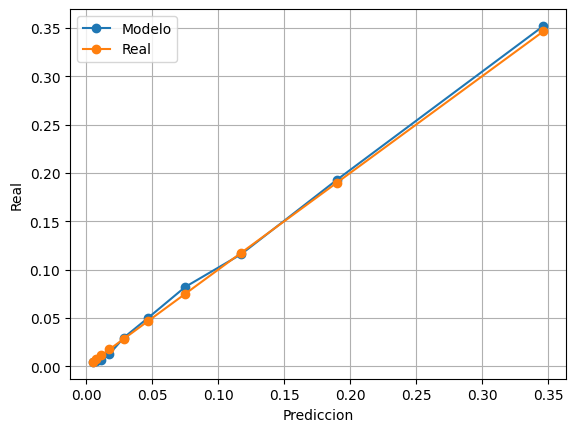

In [88]:
calibracion(nn_predictions, y_test, 10)

In [89]:
juntar = pd.DataFrame({
    'real': y_test,
    'knn': random_knn,
    'Regresion Logistica': probabilites_log_reg_random,
    'Analisis discriminante lineal' : probabilidades_modelo_disc,
    'Red Neuronal' : nn_predictions
})
juntar.head()

,real,knn,Regresion Logistica,Analisis discriminante lineal,Red Neuronal
69456,0,0.000000,0.015538,0.026620,0.015323
86614,0,0.000000,0.016742,0.025268,0.016338
61660,0,0.023256,0.051839,0.043377,0.043090
8558,0,0.046512,0.018729,0.031003,0.019833
4619,0,0.116279,0.127640,0.068178,0.130864


# Histogramas modelos

## Histograma KNN

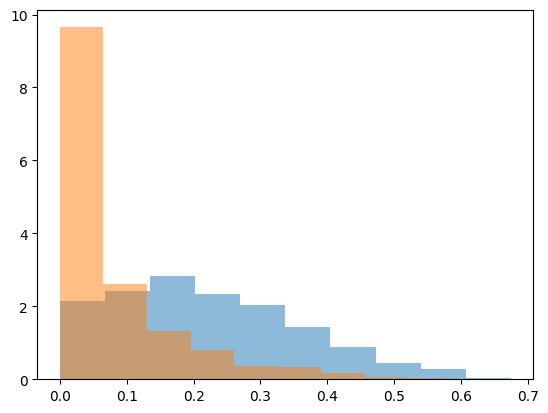

In [90]:
plt.hist(juntar[juntar['real']==1]['knn'], density=True, alpha=0.5)
plt.hist(juntar[juntar['real']==0]['knn'], density=True, alpha=0.5)
plt.show()

## Histograma Regresion Logistica

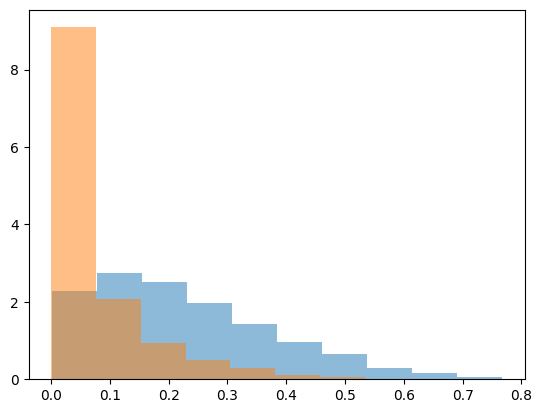

In [91]:
plt.hist(juntar[juntar['real']==1]['Regresion Logistica'], density=True, alpha=0.5)
plt.hist(juntar[juntar['real']==0]['Regresion Logistica'], density=True, alpha=0.5)
plt.show()

## Histograma Analisis discriminante lineal

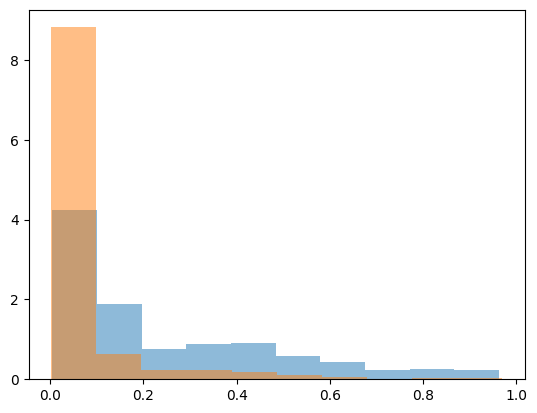

In [92]:
plt.hist(juntar[juntar['real']==1]['Analisis discriminante lineal'], density=True, alpha=0.5)
plt.hist(juntar[juntar['real']==0]['Analisis discriminante lineal'], density=True, alpha=0.5)
plt.show()

## Histograma Red Neuronal

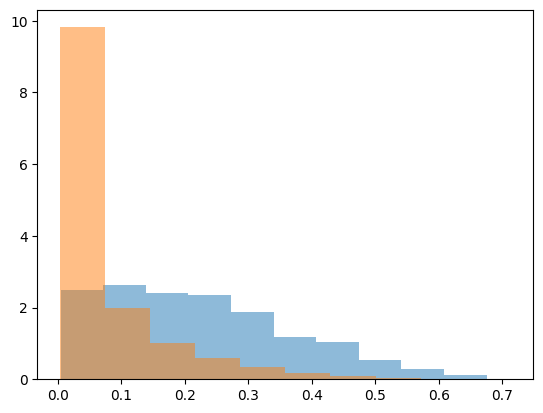

In [93]:
plt.hist(juntar[juntar['real']==1]['Red Neuronal'], density=True, alpha=0.5)
plt.hist(juntar[juntar['real']==0]['Red Neuronal'], density=True, alpha=0.5)
plt.show()

# AUC modelos

In [94]:
auc = pd.DataFrame({
    'knn': [roc_auc_score(y_score=random_knn, y_true=y_test)],
    'Regresion Logistica': [roc_auc_score(y_score=probabilites_log_reg_random, y_true=y_test)],
    'Analisis del discriminante lineal': [roc_auc_score(y_score=probabilidades_modelo_disc, y_true=y_test)],
    'Red Neuronal': [roc_auc_score(y_score=nn_predictions, y_true=y_test)]
})
auc

,knn,Regresion Logistica,Analisis del discriminante lineal,Red Neuronal
0,0.81774,0.840169,0.830784,0.839416


In [95]:
df.head()

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,80.0,0,1,25.19,0,False,False,False,False,False,True,False
1,54.0,0,0,27.32,0,False,False,False,False,False,False,False
2,28.0,0,0,27.32,0,True,False,False,False,False,True,False
3,36.0,0,0,23.45,0,False,False,True,False,False,False,False
4,76.0,1,1,20.14,0,True,False,True,False,False,False,False


# Feature Engineering

In [96]:
df['age/bmi'] = df['age'] / df['bmi']
df['age*bmi'] = df['age'] * df['bmi']

df['sqrtage'] = np.sqrt(df['age'])
df['logbmi'] = np.log(df['bmi'])
df.head()

,age,hypertension,heart_disease,bmi,diabetes,gender_Male,gender_Other,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,age/bmi,age*bmi,sqrtage,logbmi
0,80.0,0,1,25.19,0,False,False,False,False,False,True,False,3.175863,2015.20,8.944272,3.226447
1,54.0,0,0,27.32,0,False,False,False,False,False,False,False,1.976574,1475.28,7.348469,3.307619
2,28.0,0,0,27.32,0,True,False,False,False,False,True,False,1.024890,764.96,5.291503,3.307619
3,36.0,0,0,23.45,0,False,False,True,False,False,False,False,1.535181,844.20,6.000000,3.154870
4,76.0,1,1,20.14,0,True,False,True,False,False,False,False,3.773585,1530.64,8.717798,3.002708


In [97]:
target= 'diabetes'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# KNN Feature Eng

In [98]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Normalización de datos
    ('knn', KNeighborsClassifier())  
])

params_grid = {
    'knn__n_neighbors': range(1, 50), 
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean', 'manhattan'] 
}

random_seach = RandomizedSearchCV(estimator=pipeline, 
                                  param_distributions=params_grid, n_iter=15, cv=5, n_jobs=-1, scoring='roc_auc')

random_seach.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('knn', KNeighborsClassifier())]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'knn__metric': ['euclidean',
                                                        'manhattan'],
                                        'knn__n_neighbors': range(1, 50),
                                        'knn__weights': ['uniform',
                                                         'distance']},
                   scoring='roc_auc')

In [99]:
random_seach.best_params_

{'knn__weights': 'uniform', 'knn__n_neighbors': 49, 'knn__metric': 'euclidean'}

In [100]:
random_knn_fe = random_seach.best_estimator_.predict_proba(X_test)[:,1]
print("AUC", roc_auc_score(y_score=random_knn_fe, y_true=y_test))

AUC 0.8215105110896818


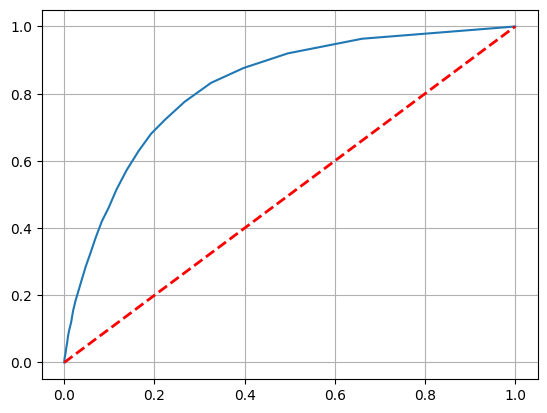

In [101]:
fpr, fnp, scores = roc_curve(y_score=random_knn_fe, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

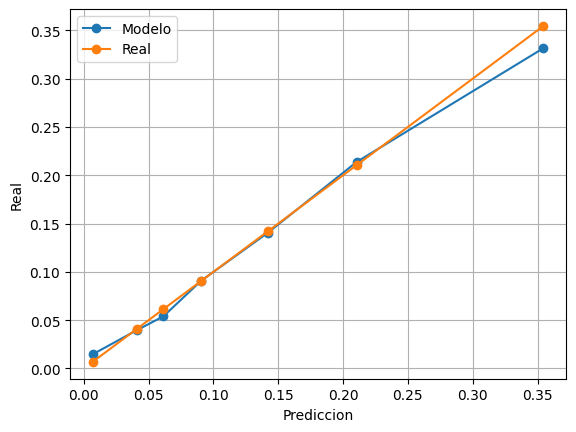

In [102]:
calibracion(random_knn_fe, y_test, 10)

# Regresion Logistica Feature Eng

In [103]:
pipeline = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),  # grado se definirá en grid search
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=10000, random_state=42))
])

params_grid = {
    'poly__degree':[1,2,3],
    'logreg__penalty':['l2', None],
    'logreg__C':[0.01, 0.1, 1]
}

In [104]:
log_reg_random = RandomizedSearchCV(estimator=pipeline, cv=5, n_jobs=-1,
                                    scoring='roc_auc',
                                    param_distributions=params_grid,
                                    n_iter=5)

log_reg_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('poly',
                                              PolynomialFeatures(include_bias=False)),
                                             ('scaler', StandardScaler()),
                                             ('logreg',
                                              LogisticRegression(max_iter=10000,
                                                                 random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'logreg__C': [0.01, 0.1, 1],
                                        'logreg__penalty': ['l2', None],
                                        'poly__degree': [1, 2, 3]},
                   scoring='roc_auc')

In [105]:
log_reg_random.best_params_

{'poly__degree': 2, 'logreg__penalty': 'l2', 'logreg__C': 1}

In [106]:
probabilites_log_reg_random_feature_eng = log_reg_random.best_estimator_.predict_proba(X_test)[:,1]

print("AUC",roc_auc_score(y_score=probabilites_log_reg_random_feature_eng, y_true=y_test))

AUC 0.8398967213114754


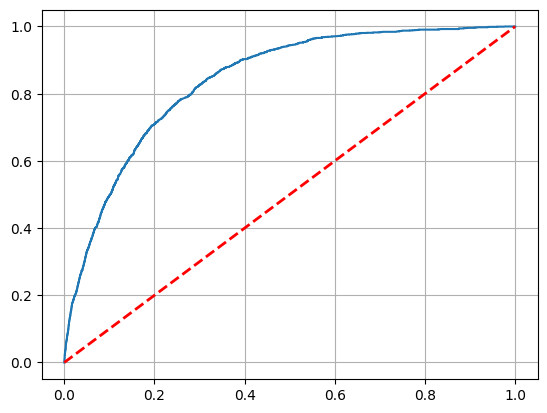

In [107]:
fpr, fnp, scores = roc_curve(y_score=probabilites_log_reg_random_feature_eng, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

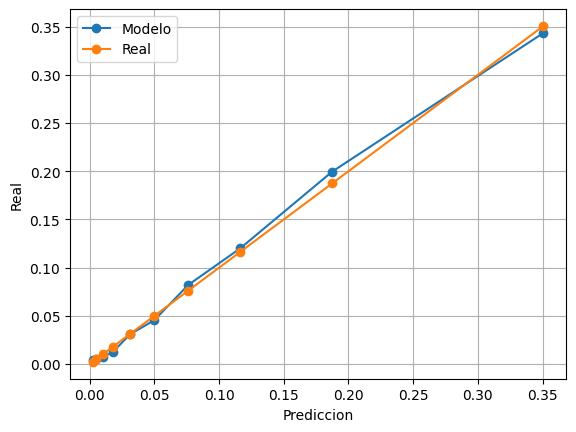

In [108]:
calibracion(probabilites_log_reg_random_feature_eng, y_test, 10)

# Variables regresion logistica feature eng

In [109]:
variables = log_reg_random.best_estimator_.named_steps['poly'].get_feature_names_out(X_train.columns)
coeficientes = log_reg_random.best_estimator_.named_steps['logreg'].coef_[0]

model_coeficientes = pd.DataFrame({
          'Variable': variables,
          'Coeficiente': coeficientes
})
model_coeficientes = model_coeficientes.sort_values(by='Coeficiente', ascending=False).head()
model_coeficientes

,Variable,Coeficiente
131,age*bmi logbmi,0.753644
130,age*bmi sqrtage,0.717949
12,age*bmi,0.708234
18,age bmi,0.708234
117,smoking_history_never age*bmi,0.571198


Analizando las variables vemos que las mas importantes al igual que sin hacerlo con feature eng, son edad y bmi, de nuevo indicandonos que las variables que mas impactan a la prediccion de una persona de si tiene diabetes o no son estas dos.

# Analisis del discriminante lineal feature eng

In [110]:
pipeline = Pipeline([
    ("scaler",  StandardScaler()),
    ("model", discriminant_analysis.LinearDiscriminantAnalysis())
])

pipeline.fit(X_train, y_train)

probabilidades_modelo_disc_fe = pipeline.predict_proba(X_test)[:, 1]
print("AUC", roc_auc_score(y_score=probabilidades_modelo_disc_fe, y_true=y_test))

AUC 0.8371042430086788


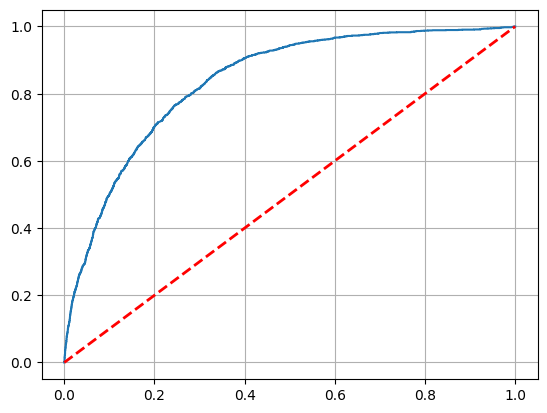

In [111]:
fpr, fnp, scores = roc_curve(y_score=probabilidades_modelo_disc_fe, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

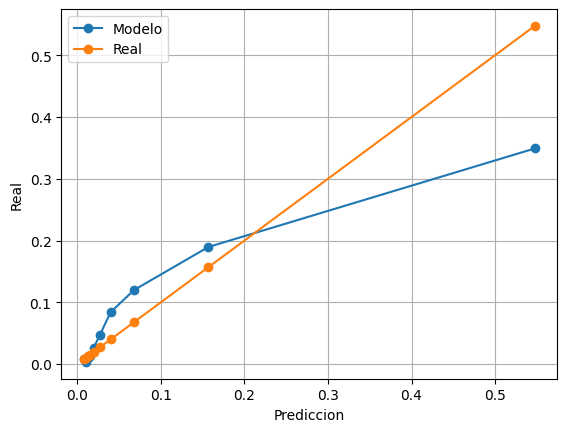

In [112]:
calibracion(probabilidades_modelo_disc_fe, y_test, 10)

# Red Neuronal Feature Eng

In [113]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('nn', MLPClassifier(max_iter=1000, random_state=42))
])

# Params grid
params_grid = {
     'nn__hidden_layer_sizes': [(50,50,50), (10,), (100,), (10,10)],
     'nn__activation': ['tanh', 'relu', 'logistic'],
     'nn__alpha': [0.1, 0.01]
}

# Fit 
grid_nn = RandomizedSearchCV(estimator=pipeline, n_jobs=-1, cv=5, scoring='roc_auc', param_distributions=params_grid)

grid_nn.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('nn',
                                              MLPClassifier(max_iter=1000,
                                                            random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'nn__activation': ['tanh', 'relu',
                                                           'logistic'],
                                        'nn__alpha': [0.1, 0.01],
                                        'nn__hidden_layer_sizes': [(50, 50, 50),
                                                                   (10,),
                                                                   (100,),
                                                                   (10, 10)]},
                   scoring='roc_auc')

In [114]:
grid_nn.best_params_

{'nn__hidden_layer_sizes': (10,), 'nn__alpha': 0.1, 'nn__activation': 'tanh'}

In [115]:
nn_predictions_fe = grid_nn.best_estimator_.predict_proba(X_test)[:,1]
print("AUC", roc_auc_score(y_score=nn_predictions_fe, y_true=y_test))

AUC 0.8391414657666345


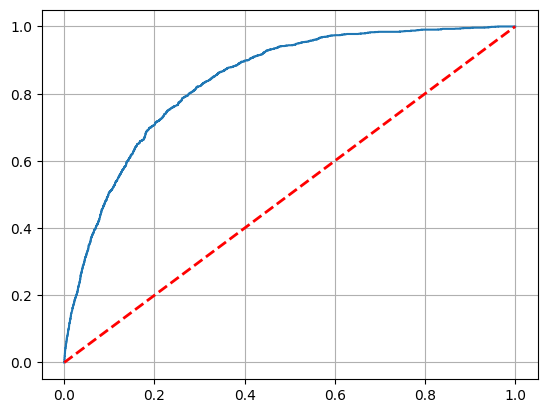

In [116]:
fpr, fnp, scores = roc_curve(y_score=nn_predictions_fe, y_true=y_test)
plt.plot(fpr, fnp)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.grid()
plt.show()

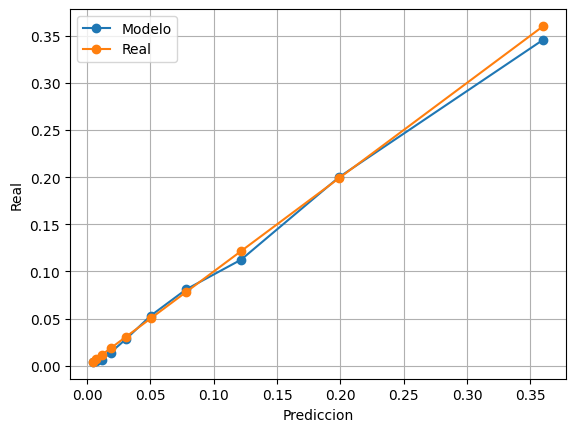

In [117]:
calibracion(nn_predictions_fe, y_test, 10)

# Histograma Modelos Feature Eng

In [118]:
juntar = pd.DataFrame({
    'real': y_test,
    'knn_fe': random_knn_fe,
    'Regresion Logistica FE': probabilites_log_reg_random_feature_eng,
    'Analisis discriminante lineal FE' : probabilidades_modelo_disc_fe,
    'Red Neuronal FE' : nn_predictions_fe
})
juntar.head()

,real,knn_fe,Regresion Logistica FE,Analisis discriminante lineal FE,Red Neuronal FE
69456,0,0.000000,0.013273,0.015584,0.015070
86614,0,0.000000,0.015406,0.014667,0.015808
61660,0,0.040816,0.052177,0.025688,0.067360
8558,0,0.040816,0.016704,0.015772,0.018958
4619,0,0.102041,0.123927,0.052205,0.133196


## Histograma KNN Feature Eng 

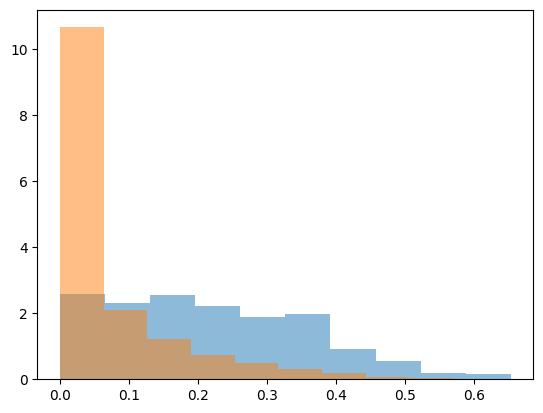

In [119]:
plt.hist(juntar[juntar['real']==1]['knn_fe'], density=True, alpha=0.5)
plt.hist(juntar[juntar['real']==0]['knn_fe'], density=True, alpha=0.5)
plt.show()

## Histograma Regresion Logistica FE

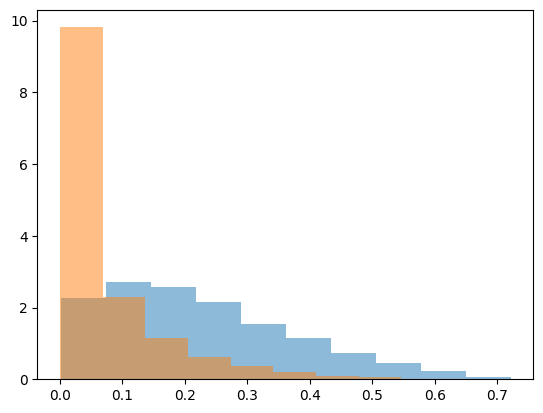

In [120]:
plt.hist(juntar[juntar['real']==1]['Regresion Logistica FE'], density=True, alpha=0.5)
plt.hist(juntar[juntar['real']==0]['Regresion Logistica FE'], density=True, alpha=0.5)
plt.show()

## Histograma Analisis discriminante lineal FE

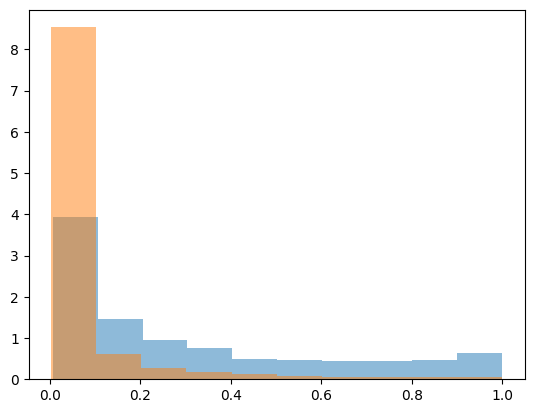

In [121]:
plt.hist(juntar[juntar['real']==1]['Analisis discriminante lineal FE'], density=True, alpha=0.5)
plt.hist(juntar[juntar['real']==0]['Analisis discriminante lineal FE'], density=True, alpha=0.5)
plt.show()

## Histograma Red Neuronal FE

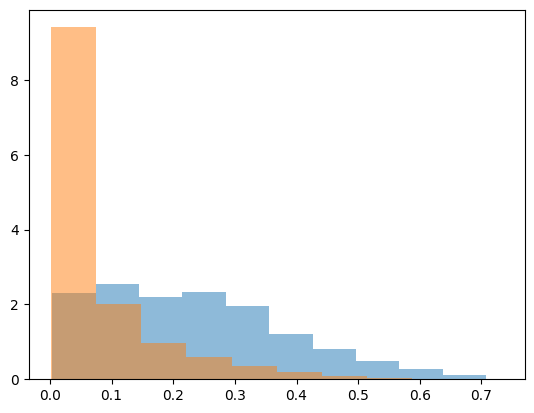

In [122]:
plt.hist(juntar[juntar['real']==1]['Red Neuronal FE'], density=True, alpha=0.5)
plt.hist(juntar[juntar['real']==0]['Red Neuronal FE'], density=True, alpha=0.5)
plt.show()

# AUC Modelos Feature Eng

In [123]:
auc = pd.DataFrame({
    'knn': [roc_auc_score(y_score=random_knn_fe, y_true=y_test)],
        'Regresion Logistica': [roc_auc_score(y_score=probabilites_log_reg_random_feature_eng, y_true=y_test)],
    'Analisis del discriminante lineal': [roc_auc_score(y_score=probabilidades_modelo_disc_fe, y_true=y_test)],
    'Red Neuronal': [roc_auc_score(y_score=nn_predictions_fe, y_true=y_test)]
})
auc

,knn,Regresion Logistica,Analisis del discriminante lineal,Red Neuronal
0,0.821511,0.839897,0.837104,0.839141


# Conclusiones

Para este dataset lo que buscamos es encontrar el mayor AUC de un grupo de personas con diabates, lo que queremos ver es con que modelo existe una mayor probabilidad de que una persona que tiene diabetes tenga una predicción mayor a una la que no.
Sin aplicar feature engineering haciendo los modelos, el modelo con el AUC mayor fue el de la regresion logistica con 0.8402 o con un 84.02% de probabilidad de que una persona con diabetes tenga una predicción mayor a la que no.

Posteriormente se crearon cuatro variables nuevas, al solamente tener edad y bmi como varaibles numericas no había mucha posibilidad de jugar con las variables y crear unas nuevas lo cual limitaba el feature eng, al volver a realizar los modelos, se llego a la conclusión de que el mejor modelo en este caso fue la regresion logistica con un 0.8399 o 83.99% de probabilidad de que una persona con diabetes tenga una predicción mayor a una a la que no lo tiene.

Analizando los histogramas podemos notar que los datos de la gente clasificada como 0 o sin diabetes estan bastante concentradas alrededor del cero, mientras que los que estan clasificados como 1 o con diabetes se distribuyen mucho más alrededor del histograma.

En general el mejor modelo fue la regresion logistica con un AUC de 0.8402 sin aplicar feature eng, como ya se menciono anteriormente solo existian dos variables numericas lo cual hizo el feature eng mas limitado y en este caso no mejoro el AUC de los modelos.
